In [1]:
import torch
from torch import nn 
import torchvision
import torch.nn.functional as F
import numpy as np 
import pandas as pd 
import os
from torchvision import transforms
from sklearn.model_selection import train_test_split
import cv2 
import numpy as np 
import pandas as pd 
import nibabel as nib
import glob
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/// Modified from :-
/// Chandhok (2021). U-net: Training image segmentation models in PyTorch [online].
/// [Accessed 5 Jul 2023]. Available from: "https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/".

 ## Data handling

In [2]:
# Get paths of image and mask files
image_paths = sorted(glob.glob('/Users/ASUS/Segmentation/IMAGES/*.png'))
mask_paths = sorted(glob.glob('/Users/ASUS/Segmentation/MASKS/*.png'))


## Data Splitting

In [3]:
# Split paths into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

In [4]:
# Print shapes of train images
for image_path in train_images:
    image = Image.open(image_path)
    print("Train Image Shape:", image.size)

# Print shapes of test images
for image_path in test_images:
    image = Image.open(image_path)
    print("Test Image Shape:", image.size)

Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Image Shape: (550, 825)
Train Imag

In [5]:
# Total number of images in the training set
num_train_images = len(train_images)
print("Number of training images:", num_train_images)

# Total number of images in the testing set
num_test_images = len(test_images)
print("Number of testing images:", num_test_images)

Number of training images: 800
Number of testing images: 200


In [6]:
# Define transformations for data preprocessing
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [7]:
class SegData(Dataset):
    def __init__(self,images,labels):
        """
        Initialize the SegData dataset.

        Args:
            images (list): List of image file paths.
            labels (list): List of label/mask file paths.
        """
        self.images=images
        self.labels=labels
    def __len__(self):
        """
        Get the total number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.images)
    def __getitem__(self, ix):
        """
        Get a single sample from the dataset.

        Args:
            ix (int): Index of the sample.

        Returns:
            tuple: Preprocessed image and mask.
        """
        image = cv2.imread(self.images[ix])
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512,512))
        mask = cv2.imread(self.labels[ix])
        mask = cv2.resize(mask, (512,512))
        mask=cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
        return image, mask
    def choose(self):
        """
        Choose a random sample from the dataset.

        Returns:
            tuple: Preprocessed image and mask.
        """
        return self[randint(len(self))]
    def collate_fn(self, batch):
        """
        Collate function for batching samples.

        Args:
            batch (list): List of samples.

        Returns:
            tuple: Batched images and masks.
        """
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask)[None] for mask in masks]).long().to(device)
        return ims, ce_masks

In [8]:
# Create train and test datasets
train_dataset=SegData(train_images,train_labels)
test_dataset=SegData(test_images,test_labels)

## Data Visualisation

(512, 512, 3)
(512, 512)
(512, 512, 3)
41


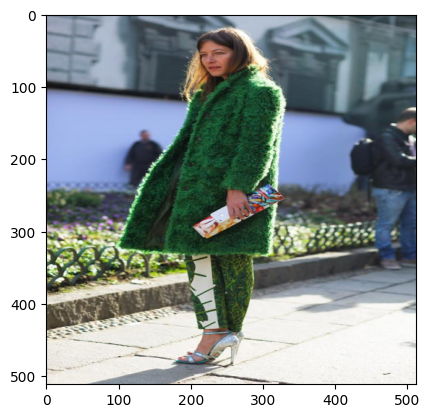

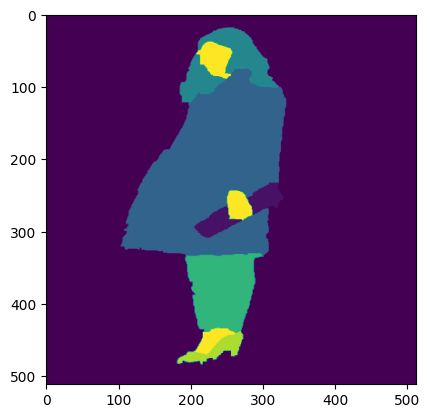

In [9]:
# Get an example from the train dataset
image,mask=train_dataset[7]
print(image.shape)
print(mask.shape)

# Display the image and mask
plt.imshow(image)
plt.figure()
plt.imshow(mask)
print(image.shape)
print(mask.max())

## Model Architecture

/// The following section has been modified from :-
/// Rishikesh (2020). ResUnet: Pytorch implementation of ResUnet and ResUnet ++.[online]. [Accessed 5 Jul 2023]. 
/// Available from: "https://github.com/rishikksh20/ResUnet".

In [10]:
def conv(nin,nout,kernel_size): #Creates a convolutional block with convolution, batch normalization, and ReLU activation.
  return nn.Sequential(
          nn.Conv2d(nin,nout, kernel_size=kernel_size,padding="same"),
          nn.BatchNorm2d(nout),
          nn.ReLU(inplace=True))
  
class resconv(nn.Module): #Residual convolutional block
  def __init__(self,in_features,out_features):
    super(resconv,self).__init__()
    self.block=nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_features,out_features,3),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(out_features,out_features,3),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),
        
    )
  def forward(self,x): #Forward pass of the residual convolutional block.
      return x+self.block(x)

def up_conv(nin,nout): #Creates an upsampling convolutional block with transpose convolution, instance normalization, and ReLU activation.
  return nn.Sequential(
      nn.ConvTranspose2d(nin,nout,kernel_size=2,stride=2),
      nn.InstanceNorm2d(nout),
      nn.ReLU(),
  )

In [11]:
class ResUnet1(nn.Module): #Residual U-Net architecture for segmentation.
  def __init__(self):
    super().__init__()
    self.block1=conv(3,64,(7,7))
    self.max_pool=nn.MaxPool2d(2,stride=2)
    self.block2=conv(64,128,(1,1))
    self.block3=conv(128,256,(1,1))
    self.block4=conv(256,512,(1,1))
    self.block2_1=resconv(64,64)
    self.block3_1=resconv(128,128)
    self.block4_1=resconv(256,256)
    self.block_5_1=resconv(512,512)
    self.upconv5=up_conv(512,512)
    self.upconv4=up_conv(512,256)
    self.upconv3=up_conv(256,128)
    self.upconv2=up_conv(128,64)
    self.conv6=conv(512+512,512,kernel_size=(3,3))
    self.conv5=conv(256+256,256,kernel_size=(3,3))
    self.conv4=conv(128+128,128,kernel_size=(3,3))
    self.conv3=conv(64+64,64,kernel_size=(3,3))
    self.last_conv=nn.Conv2d(64,59,kernel_size=(1,1),padding="same")
  def forward(self,x): #Forward pass of the Residual U-Net architecture.
    x1=self.block1(x)
    x2=self.max_pool(x1)
    x3=self.block2_1(x2)
    x4=self.block2(x3)
    x5=self.max_pool(x4)
    x6=self.block3_1(x5)
    x7=self.block3(x6)
    x8=self.max_pool(x7)
    x9=self.block4_1(x8)
    x10=self.block4(x9)
    x11=self.max_pool(x10)
    x12=self.block_5_1(x11)
    y12=self.upconv5(x12)
    y_out1=torch.cat([y12,x10],dim=1)
    y_out1=self.conv6(y_out1)
    y11=self.upconv4(y_out1)
    y_out2=torch.cat([y11,x7],dim=1)
    y_out2=self.conv5(y_out2)
    y10=self.upconv3(y_out2)
    y_out3=torch.cat([y10,x4],dim=1)
    y_out3=self.conv4(y_out3)
    y9=self.upconv2(y_out3)
    y_out=torch.cat([y9,x1],dim=1)
    y_out=self.conv3(y_out)
    out=self.last_conv(y_out)
    return out

/// end of Citation

In [12]:
model=ResUnet1()
model=model.to(device)

In [13]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    """Computes the loss and accuracy for the U-Net model predictions.

    Args:
        preds (torch.Tensor): Predicted masks.
        targets (torch.Tensor): Target masks.

    Returns:
        tuple: Cross-entropy loss and accuracy.
    """
    ce_loss = ce(preds, targets)
    acc = (torch.argmax(preds,1) == targets).float().mean()
    return ce_loss, acc

In [14]:
criterion=UnetLoss
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,gamma=0.5,step_size=15)

In [15]:
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=8,shuffle=True,collate_fn=train_dataset.collate_fn)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=8,shuffle=False,collate_fn=test_dataset.collate_fn)

In [16]:
image,mask=next(iter(train_dataloader))
image.shape

torch.Size([8, 3, 512, 512])

## Training

In [17]:
def train_batch(model, data, optimizer, criterion):
    """Performs a single training step on a batch of data.

    Args:
        model (nn.Module): The model to be trained.
        data (tuple): Input data and corresponding labels.
        optimizer (torch.optim.Optimizer): The optimizer to update the model parameters.
        criterion (function): Loss function to compute the loss.

    Returns:
        float: Loss value.
        float: Accuracy value.
    """
    ims, ce_masks = data
    ims=ims
    ce_masks=ce_masks
    model.train()
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()
@torch.no_grad()
def valid_batch(model, data, criterion):
    """Performs a validation step on a batch of data.

    Args:
        model (nn.Module): The model to be evaluated.
        data (tuple): Input data and corresponding labels.
        criterion (function): Loss function to compute the loss.

    Returns:
        float: Loss value.
        float: Accuracy value.
    """
    model.eval()
    ims, ce_masks = data
    ims=ims
    ce_masks=ce_masks
    _masks = model(ims)
    loss, acc = criterion(_masks, ce_masks)
    return loss.item(), acc.item()

In [18]:
n_epochs = 5
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(n_epochs):
    # Training
    model.train()
    train_loss_total = 0.0
    train_acc_total = 0.0
    num_train_batches = len(train_dataloader)

    for batch_idx, data in enumerate(train_dataloader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        train_loss_total += loss
        train_acc_total += acc

        progress = (batch_idx + 1) / num_train_batches
        print(f"Epoch [{epoch + 1}/{n_epochs}], Train Batch [{batch_idx + 1}/{num_train_batches}], "
              f"Train Loss: {loss:.4f}, Train Acc: {acc:.4f}, Progress: {progress * 100:.2f}%       ", end="\r")

    average_train_loss = train_loss_total / num_train_batches
    average_train_acc = train_acc_total / num_train_batches
    train_losses.append(average_train_loss)
    train_accs.append(average_train_acc)

    # Validation
    model.eval()
    val_loss_total = 0.0
    val_acc_total = 0.0
    num_val_batches = len(test_dataloader)

    for batch_idx, data in enumerate(test_dataloader):
        loss, acc = valid_batch(model, data, criterion)
        val_loss_total += loss
        val_acc_total += acc

        progress = (batch_idx + 1) / num_val_batches
        print(f"Epoch [{epoch + 1}/{n_epochs}], Validation Batch [{batch_idx + 1}/{num_val_batches}], "
              f"Val Loss: {loss:.4f}, Val Acc: {acc:.4f}, Progress: {progress * 100:.2f}%       ", end="\r")

    average_val_loss = val_loss_total / num_val_batches
    average_val_acc = val_acc_total / num_val_batches
    val_losses.append(average_val_loss)
    val_accs.append(average_val_acc)

    print(f"\nEpoch [{epoch + 1}/{n_epochs}], Average Train Loss: {average_train_loss:.4f}, "
          f"Average Train Acc: {average_train_acc:.4f}")
    print(f"Epoch [{epoch + 1}/{n_epochs}], Average Validation Loss: {average_val_loss:.4f}, "
          f"Average Validation Acc: {average_val_acc:.4f}")

    scheduler.step()
    

Epoch [1/5], Validation Batch [25/25], Val Loss: 1.0162, Val Acc: 0.7951, Progress: 100.00%        
Epoch [1/5], Average Train Loss: 1.9411, Average Train Acc: 0.7084
Epoch [1/5], Average Validation Loss: 1.0954, Average Validation Acc: 0.7791
Epoch [2/5], Validation Batch [25/25], Val Loss: 0.7942, Val Acc: 0.7994, Progress: 100.00%        
Epoch [2/5], Average Train Loss: 0.9235, Average Train Acc: 0.7874
Epoch [2/5], Average Validation Loss: 0.8727, Average Validation Acc: 0.7939
Epoch [3/5], Validation Batch [25/25], Val Loss: 0.7251, Val Acc: 0.8164, Progress: 100.00%        
Epoch [3/5], Average Train Loss: 0.8156, Average Train Acc: 0.8001
Epoch [3/5], Average Validation Loss: 0.8022, Average Validation Acc: 0.8063
Epoch [4/5], Validation Batch [25/25], Val Loss: 0.6778, Val Acc: 0.8280, Progress: 100.00%        
Epoch [4/5], Average Train Loss: 0.7627, Average Train Acc: 0.8094
Epoch [4/5], Average Validation Loss: 0.7565, Average Validation Acc: 0.8111
Epoch [5/5], Validation 

## Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


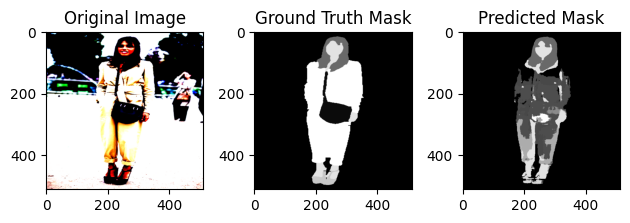

In [19]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=test_dataset.collate_fn)

with torch.no_grad():
    model.eval()
    img, mask = next(iter(test_dataloader))
    _mask = model(img)
    _, _mask_m = torch.max(_mask, dim=1)

    # Display original image
    plt.subplot(131)
    plt.imshow(img[0].detach().cpu().permute(1, 2, 0).numpy())
    plt.title('Original Image')

    # Display ground truth mask
    plt.subplot(132)
    plt.imshow(mask[0].detach().cpu().numpy(), cmap='gray')
    plt.title('Ground Truth Mask')

    # Display predicted mask
    plt.subplot(133)
    plt.imshow(_mask_m[0].detach().cpu().numpy(), cmap='gray')
    plt.title('Predicted Mask')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


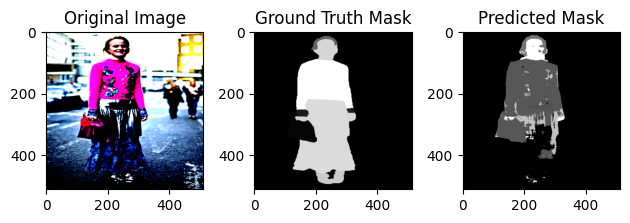

In [20]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=test_dataset.collate_fn)

with torch.no_grad():
    model.eval()
    img, mask = next(iter(test_dataloader))
    _mask = model(img)
    _, _mask_m = torch.max(_mask, dim=1)

    # Display original image
    plt.subplot(131)
    plt.imshow(img[0].detach().cpu().permute(1, 2, 0).numpy())
    plt.title('Original Image')

    # Display ground truth mask
    plt.subplot(132)
    plt.imshow(mask[0].detach().cpu().numpy(), cmap='gray')
    plt.title('Ground Truth Mask')

    # Display predicted mask
    plt.subplot(133)
    plt.imshow(_mask_m[0].detach().cpu().numpy(), cmap='gray')
    plt.title('Predicted Mask')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


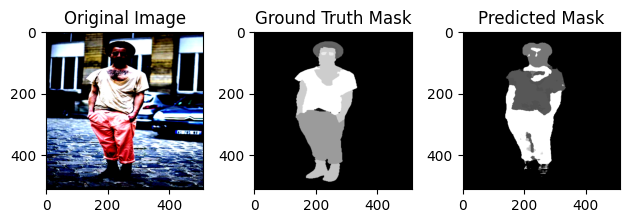

In [21]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=test_dataset.collate_fn)

with torch.no_grad():
    model.eval()
    img, mask = next(iter(test_dataloader))
    _mask = model(img)
    _, _mask_m = torch.max(_mask, dim=1)

    # Display original image
    plt.subplot(131)
    plt.imshow(img[0].detach().cpu().permute(1, 2, 0).numpy())
    plt.title('Original Image')

    # Display ground truth mask
    plt.subplot(132)
    plt.imshow(mask[0].detach().cpu().numpy(), cmap='gray')
    plt.title('Ground Truth Mask')

    # Display predicted mask
    plt.subplot(133)
    plt.imshow(_mask_m[0].detach().cpu().numpy(), cmap='gray')
    plt.title('Predicted Mask')

    plt.tight_layout()
    plt.show()

 ## Unit Tests

In [22]:
class CodeTests:
    def test_dataset_image_loading(self): # Test the loading of images from the dataset.
        train_dataset = SegData(train_images, train_labels)
        image, mask = train_dataset[0]
        assert isinstance(image, np.ndarray)
        assert isinstance(mask, np.ndarray)
        assert image.shape == (512, 512, 3)
        assert mask.shape == (512, 512)

    def test_data_loader(self): #Test the data loader functionality.
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=8, shuffle=True, collate_fn=train_dataset.collate_fn
        )
        images, masks = next(iter(train_dataloader))
        assert isinstance(images, torch.Tensor)
        assert isinstance(masks, torch.Tensor)
        assert images.shape == (8, 3, 512, 512)
        assert masks.shape == (8, 512, 512)

    def test_model_forward_pass(self): #Test the forward pass of the model.
        model = ResUnet1()
        images = torch.randn(8, 3, 512, 512)
        masks = torch.randint(0, 59, (8, 512, 512))
        output = model(images)
        assert isinstance(output, torch.Tensor)
        assert output.shape == (8, 59, 512, 512)

    def test_train_batch(self): #Test the training batch function.
        model = ResUnet1()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = UnetLoss
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=8, shuffle=True, collate_fn=train_dataset.collate_fn
        )
        images, masks = next(iter(train_dataloader))
        loss, acc = train_batch(model, (images, masks), optimizer, criterion)
        assert isinstance(loss, float)
        assert isinstance(acc, float)

    def test_valid_batch(self): #Test the validation batch function.
        model = ResUnet1()
        criterion = UnetLoss
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset, batch_size=8, shuffle=False, collate_fn=test_dataset.collate_fn
        )
        images, masks = next(iter(test_dataloader))
        loss, acc = valid_batch(model, (images, masks), criterion)
        assert isinstance(loss, float)
        assert isinstance(acc, float)


# Instantiate the class and run the tests
test_runner = CodeTests()
test_runner.test_dataset_image_loading()
test_runner.test_data_loader()
test_runner.test_model_forward_pass()
test_runner.test_train_batch()
test_runner.test_valid_batch()
